# Regression models for soft sensing of a real process

In this notebook, the application of regression techniques for monitoring is demonstrated, using real process data samples available on `BibMon`.

In [1]:
import bibmon
import pandas as pd
import matplotlib.pyplot as plt

## Importing data

To import the data in question, you must use the `load_real_process_data()` function:

In [2]:
df_raw = bibmon.load_real_data()

In this DataFrame, variables were standardized prior to publication to ensure confidentiality.

As there are non-numeric values, data processing is necessary. You can use the `pd.to_numeric()` function to convert the DataFrame columns to numeric values:

In [3]:
df_num = df_raw.apply(pd.to_numeric, errors='coerce')

The `errors='coerce'` argument specifies that all values that could not be converted to numbers are transformed into NaN (Not a Number).

It is good practice to check which strings were converted, as some variables may be categorical in nature and contain relevant information (for example, Boolean variables of the type 'On/Off', 'Open/Closed', etc.). In these cases, it would not make sense to replace the values with NaN.

In [4]:
tags_nans = df_num.columns[df_num.isna().any()].tolist()
tags_nans

print('Quantity, by tag, of strings being changed to NaN:\n')

for tag in tags_nans:
    print(tag, 
          df_raw[tag].loc[df_raw[tag][df_num[tag].isnull()].index].unique().tolist(),
          df_num[tag].isnull().sum())

Quantity, by tag, of strings being changed to NaN:

tag2 ['Inp OutRange'] 156
tag34 ['Bad'] 14
tag36 ['Scan Timeout'] 1
tag70 ['Bad'] 326
tag72 ['Scan Timeout'] 1


It appears that in all cases the replacement with NaN was adequate.

According to the default data preprocessing implemented in `BibMon`, the NaN values of the training data will be replaced by the last valid value and the NaN values of the test data will be replaced by the median of the training set. For more preprocessing options, see the functions programmed in the `PreProcess` class.

## Modeling and process monitoring

In offline analyzes at `BibMon`, we usually separate the data set into training, validation and testing. The training data is used to generate the model. Validation data is used to evaluate model performance and reset the fault detection threshold to compensate for small levels of training overfitting. The test data is also used to evaluate the model's performance, but with the new threshold and possibly containing faulty periods.

If one wants to perform training-validation-test splitting on consecutive date ranges, the `train_val_test_split` function provides a practical way to do so:

In [5]:
(X_train, X_validation, 
 X_test, Y_train, 
 Y_validation, Y_test) = bibmon.train_val_test_split(df_num, 
                                                     start_train = '2017-12-24T12:00', 
                                                     end_train = '2018-01-01T00:00', 
                                                     end_validation = '2018-01-02T00:00', 
                                                     end_test = '2018-01-04T00:00',
                                                     tags_Y = 'tag100')

Notice how we separated the data into predictor ($X$) and predicted ($y$) variables. In regression applications, the goal is to create a model that predicts $y$ values based on $X$ values; that is, to establish a $y = f(X)$ relationship. In `BibMon`, regression models are used to establish this relationship using normal, training data. If this relationship is disrupted by new data, the process is considered to be in an abnormal state and alarms are triggered.

The fault detection index used by `BibMon` is the Squared Prediction Error (SPE). This index is based on the difference between the measured $y$ values and the $\hat{y}$ values predicted by the model:

$$ \text{SPE}_i = (y_{i} - \hat{y}_{i})^2 $$

Higher SPE values indicate a greater likelihood that the captured regression model does not adequately explain the relationships between $X$ and $y$ in the data, suggesting that the process is not in its normal state.

Let's use the class `sklearnRegressor`, which is initialized by receiving a scikit-learn regression estimator:

In [6]:
from sklearn.ensemble import RandomForestRegressor  
reg = RandomForestRegressor(n_jobs=-1, random_state=1)

model = bibmon.sklearnRegressor(reg) 

Defining the regression metrics to display:

In [7]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

mtr = [r2_score, mean_absolute_error]

The `complete_analysis` function automates the processes of training, validation, and testing, offering a comprehensive overview of the entire analysis. It displays SPE control charts on the left and regression plots on the right:

CPU times: total: 22.6 s
Wall time: 3.31 s


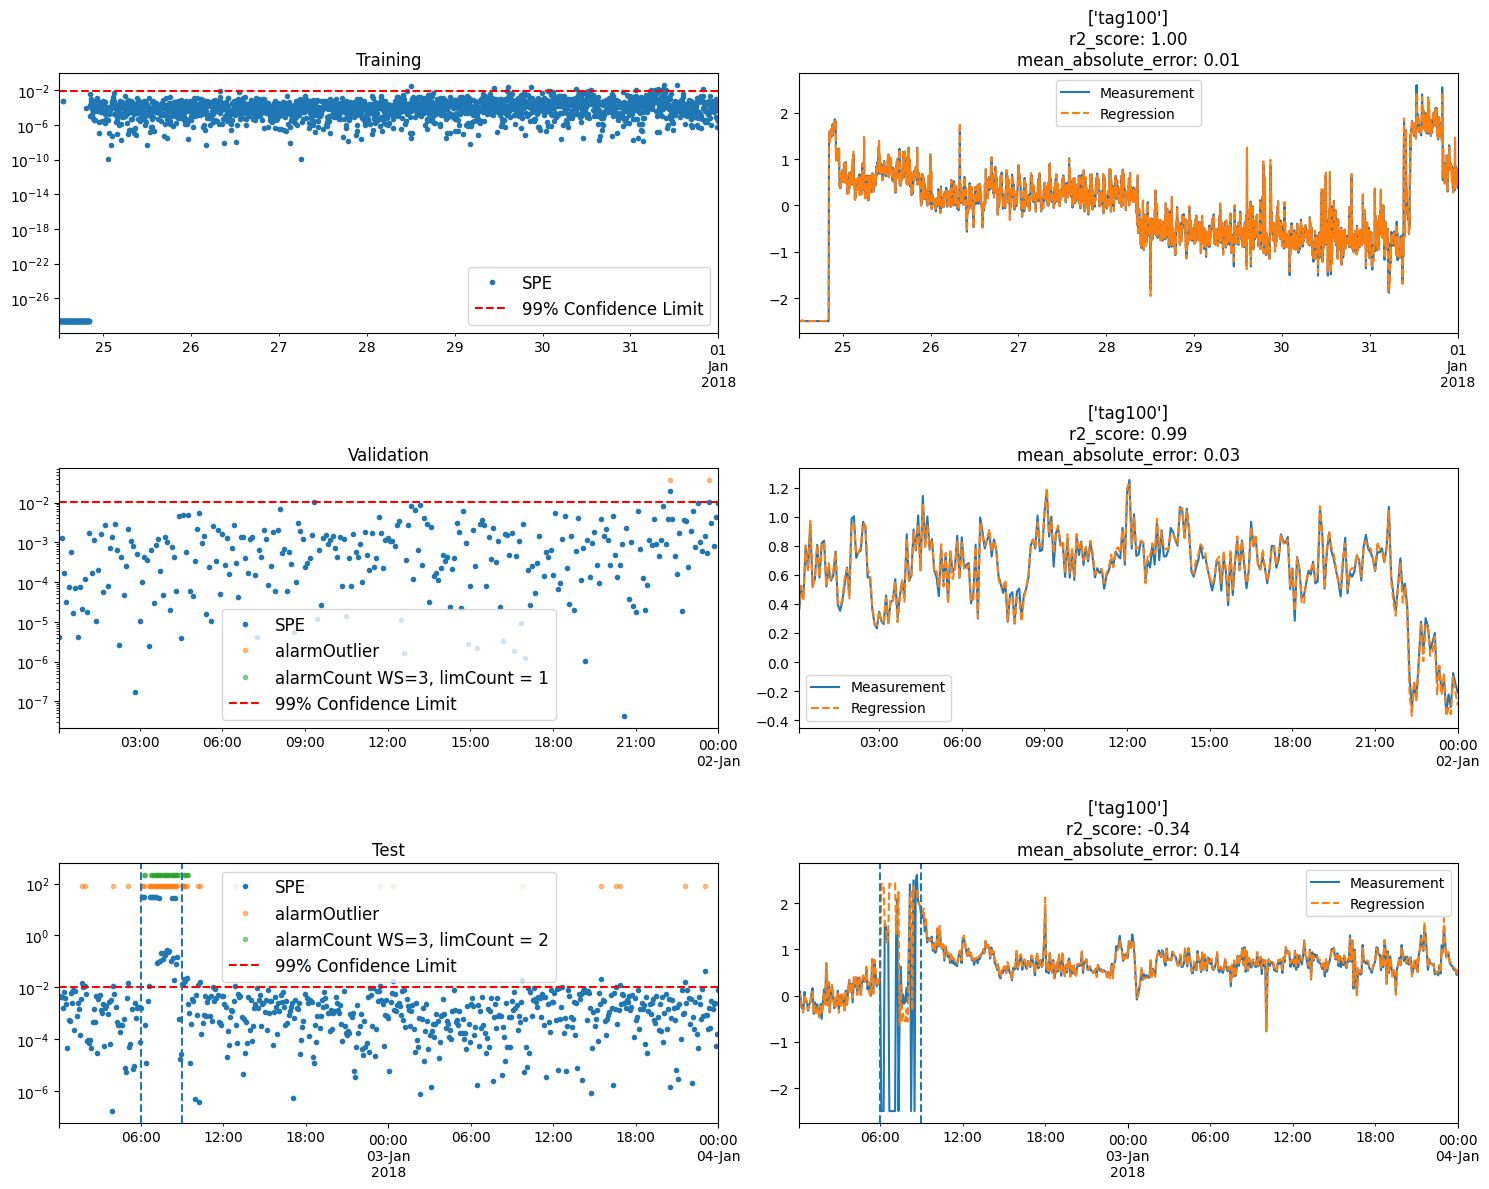

In [8]:
%%time
bibmon.complete_analysis(model, X_train, X_validation, X_test, 
                         Y_train, Y_validation, Y_test,                    
                         metrics = mtr, count_window_size = 3, count_limit = 2,
                         fault_start = '2018-01-02 06:00:00',
                         fault_end = '2018-01-02 09:00:00')                       

It is notable that using `alarmCount` (which in the case above only triggers when, in a window of 3 points, 2 points are above the limit) significantly reduces the number of false alarms.

## Comparing models

### The `comparative_table` function

The `comparative_table` function makes it possible to compare several models.

To do this, we will define the regression models in a list:

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

sklearn_regs = [LinearRegression(), LassoCV(), SVR(), 
                RandomForestRegressor(n_jobs=-1,random_state=1), 
                MLPRegressor()]

models = [bibmon.sklearnRegressor(reg) for reg in sklearn_regs]

The API of `comparative_table` is practically the same as the `complete_analysis` function, with the difference that a list of models must be provided as the first argument (along with some additional optional arguments, not shown here).

CPU times: total: 27.9 s
Wall time: 9.1 s


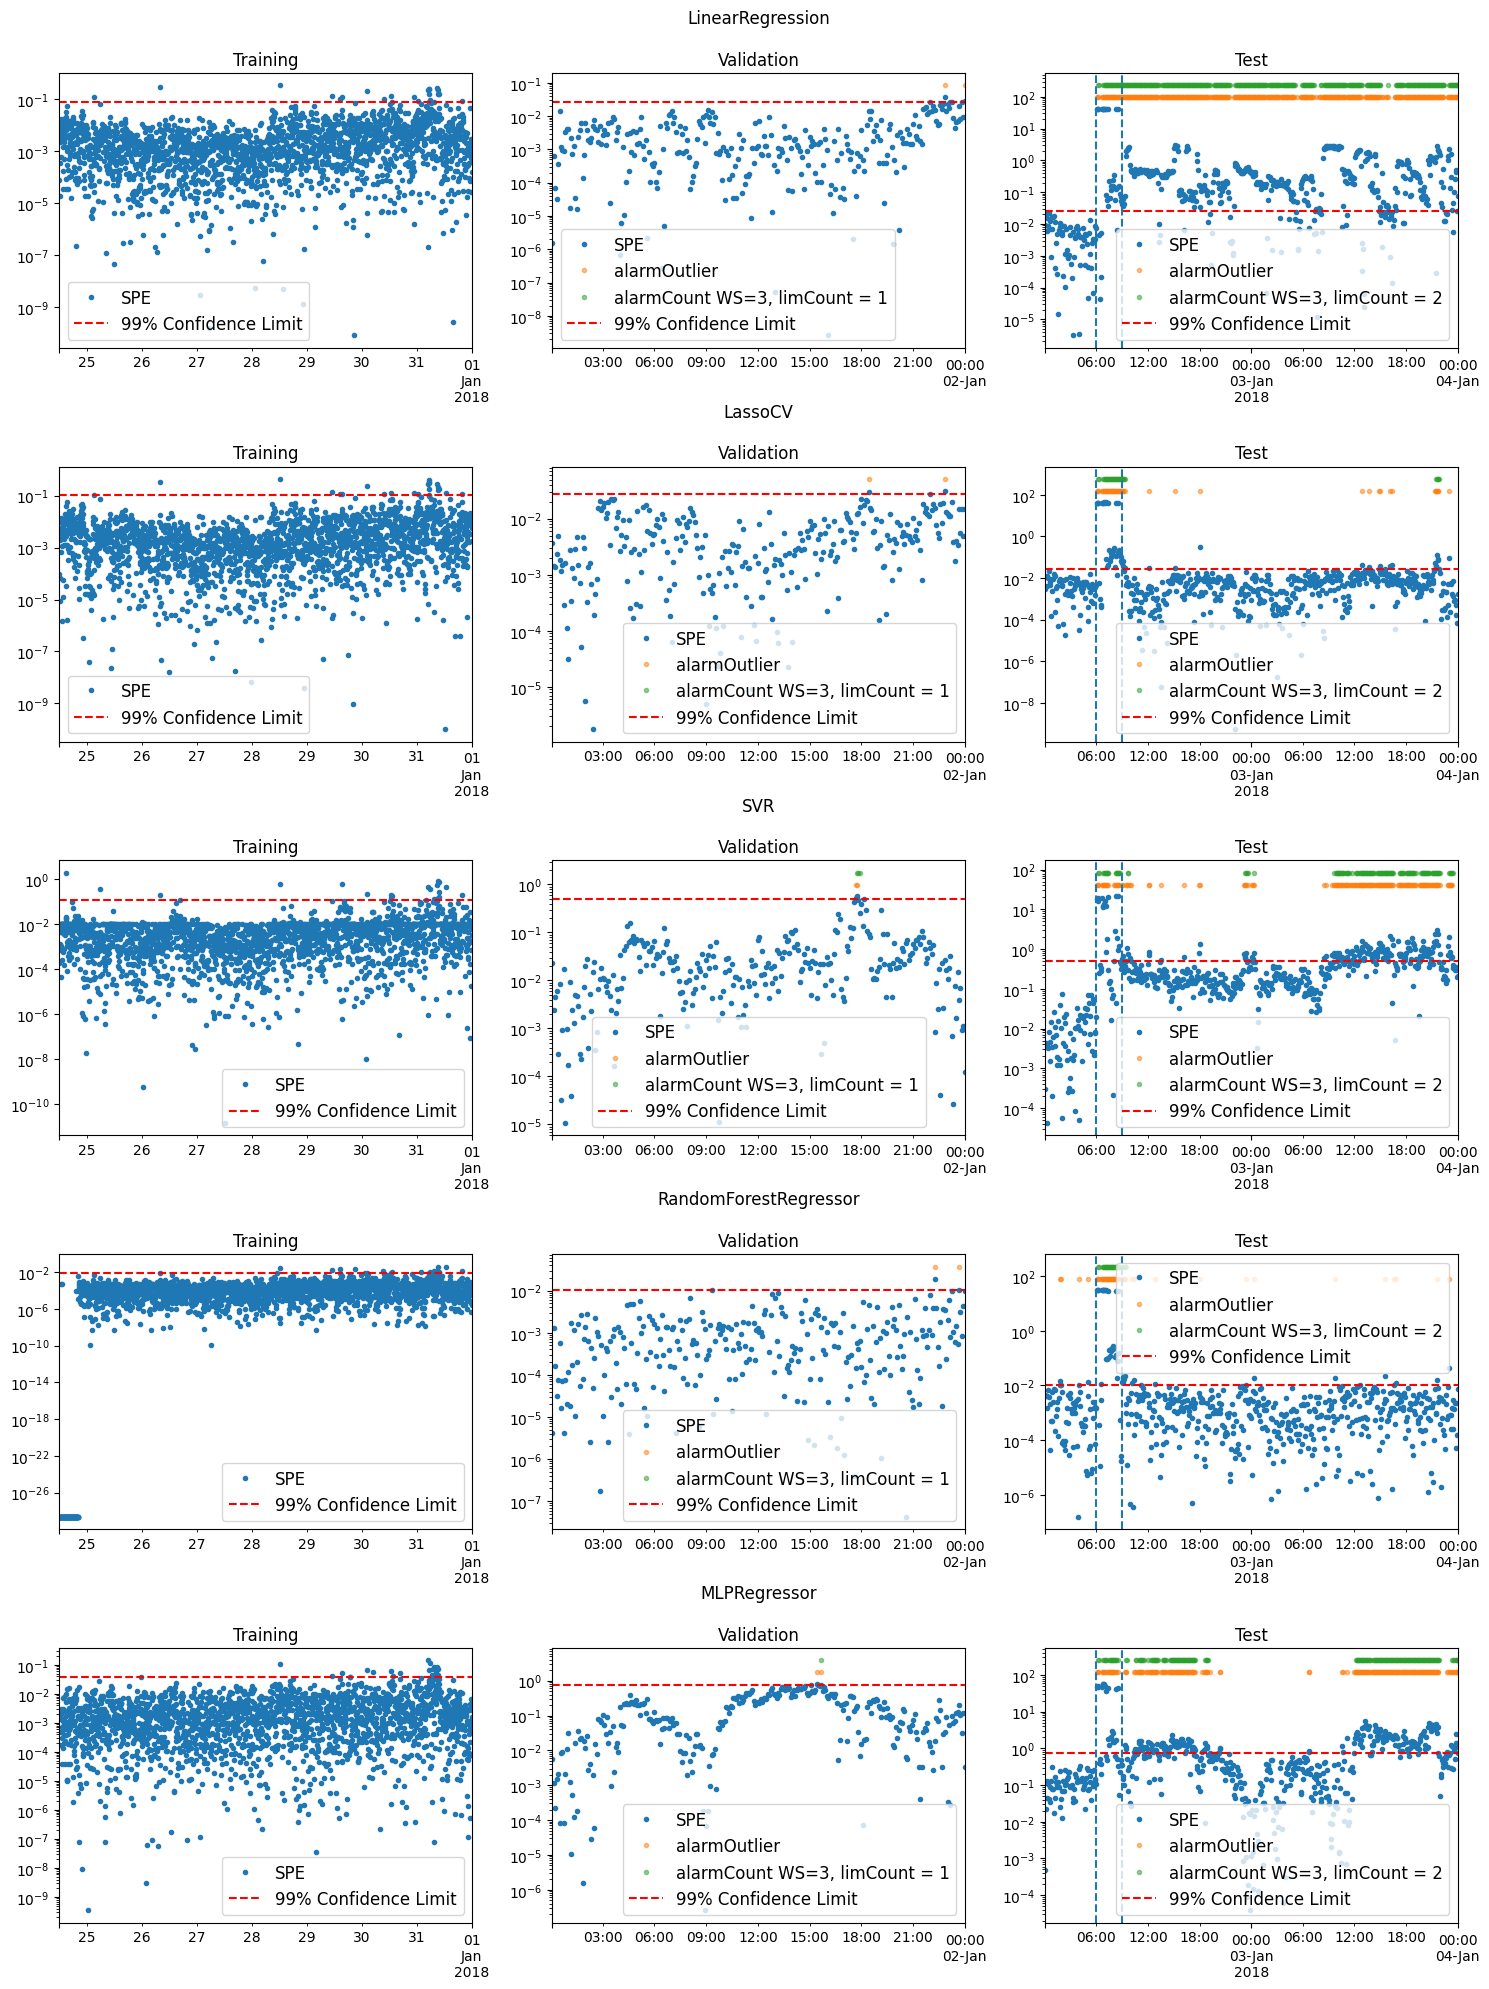

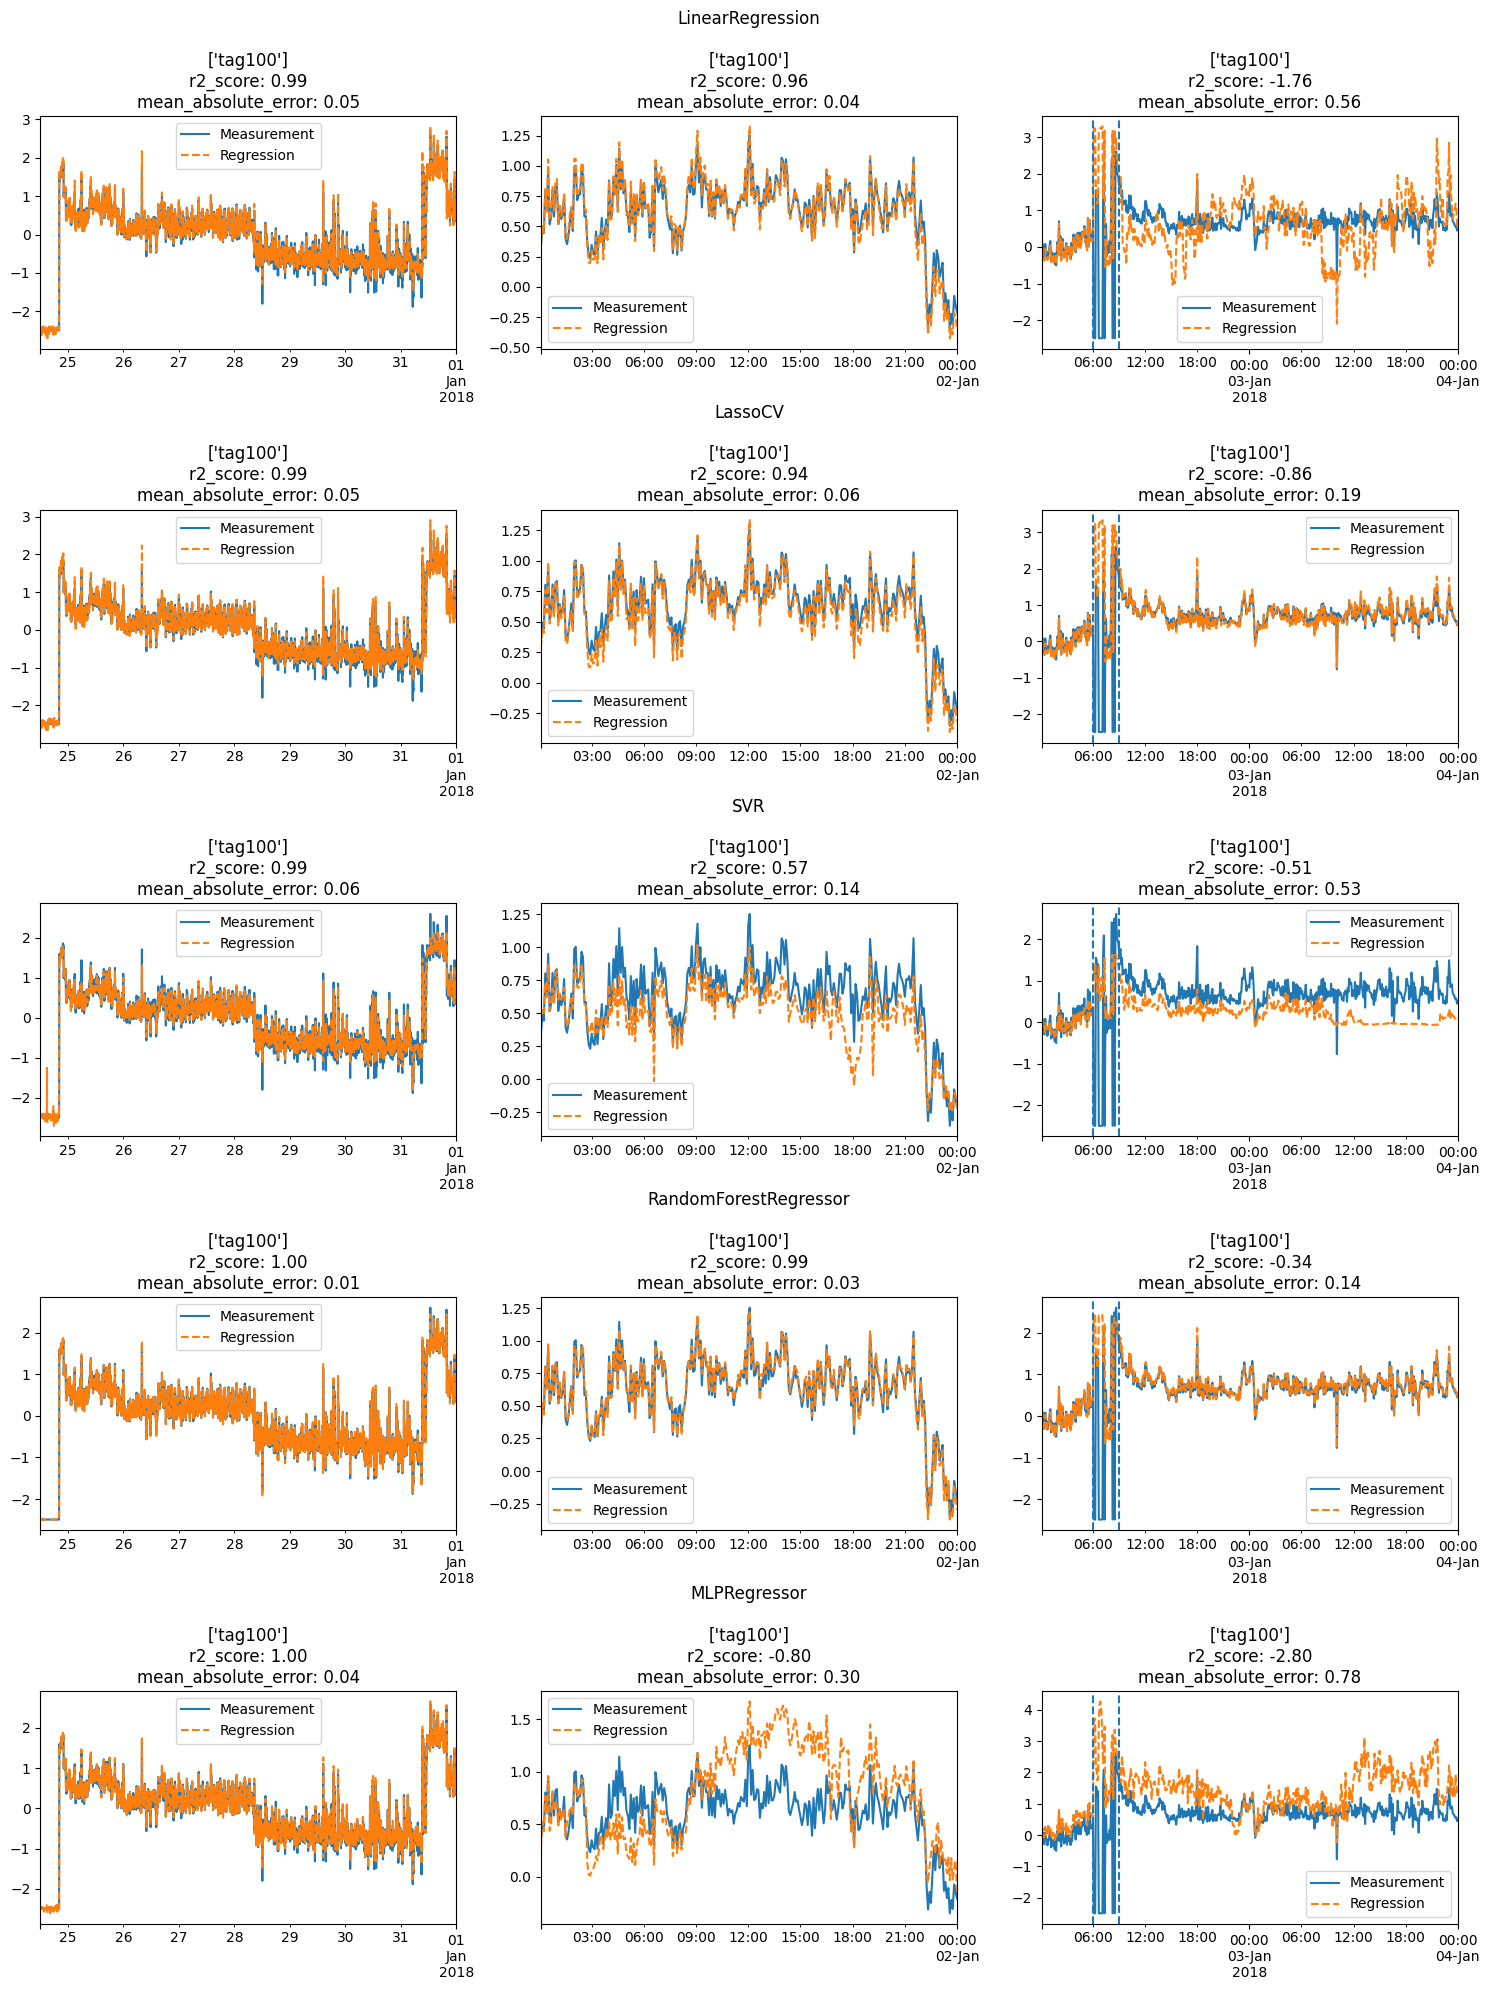

In [10]:
%%time
tab_pred, tab_detec, tab_times = bibmon.comparative_table(models, X_train, X_validation, X_test, 
                                                          Y_train, Y_validation, Y_test,                      
                                                          metrics = mtr, count_window_size = 3, count_limit = 2,
                                                          fault_start = '2018-01-02 06:00:00',
                                                          fault_end = '2018-01-02 09:00:00')                       

Visualizing the prediction metrics table:

In [11]:
tab_pred.round(3)

Train  Validation   Test
Metrics             Models                                         
mean_absolute_error LassoCV                0.051       0.058  0.190
                    LinearRegression       0.047       0.043  0.561
                    MLPRegressor           0.041       0.301  0.782
                    RandomForestRegressor  0.012       0.025  0.144
                    SVR                    0.060       0.143  0.533
r2_score            LassoCV                0.993       0.940 -0.865
                    LinearRegression       0.994       0.959 -1.757
                    MLPRegressor           0.996      -0.802 -2.801
                    RandomForestRegressor  1.000       0.986 -0.335
                    SVR                    0.990       0.567 -0.515

Visualizing the alarms table:

In [12]:
tab_detec.round(3)

FDR    FAR
Alarms                        Models                             
alarmCount WS=3, limCount = 2 LassoCV                0.778  0.019
                              LinearRegression       0.778  0.720
                              MLPRegressor           0.528  0.350
                              RandomForestRegressor  0.750  0.007
                              SVR                    0.472  0.226
alarmOutlier                  LassoCV                0.833  0.037
                              LinearRegression       0.833  0.741
                              MLPRegressor           0.611  0.380
                              RandomForestRegressor  0.806  0.039
                              SVR                    0.528  0.269

Visualizing the table of computational times (measured in seconds per million processed observations):

In [13]:
tab_times.round(2)

,Train,Test
LinearRegression,9.68,1.84
LassoCV,44.22,0.00
SVR,83.13,38.06
RandomForestRegressor,874.11,61.51
MLPRegressor,541.06,0.00


By default, the tables are organized with the models at the second level of index depth. However, it is possible to invert and place the models at the first level.

In [14]:
tab_pred.swaplevel().sort_index(axis=0).round(3)

Train  Validation   Test
Models                Metrics                                      
LassoCV               mean_absolute_error  0.051       0.058  0.190
                      r2_score             0.993       0.940 -0.865
LinearRegression      mean_absolute_error  0.047       0.043  0.561
                      r2_score             0.994       0.959 -1.757
MLPRegressor          mean_absolute_error  0.041       0.301  0.782
                      r2_score             0.996      -0.802 -2.801
RandomForestRegressor mean_absolute_error  0.012       0.025  0.144
                      r2_score             1.000       0.986 -0.335
SVR                   mean_absolute_error  0.060       0.143  0.533
                      r2_score             0.990       0.567 -0.515

### Variable importance analysis

It is possible to calculate variable importances for all models derived from `scikit-learn`. Some models calculate this importance value natively; however, for other models, it can be calculated by specifying the argument `permutation_importance=True` during initialization.

To visualize the importances, the method `plot_importances` should be used. Let's do this with `RandomForestRegressor`:

tag102    9.938623e-01
tag104    9.177516e-04
tag105    5.817841e-04
tag97     2.527571e-04
tag15     2.406199e-04
              ...     
tag57     3.597982e-06
tag64     2.145157e-06
tag63     1.043737e-06
tag67     3.829644e-07
tag95     4.681209e-08
Name: Importances, Length: 91, dtype: float64

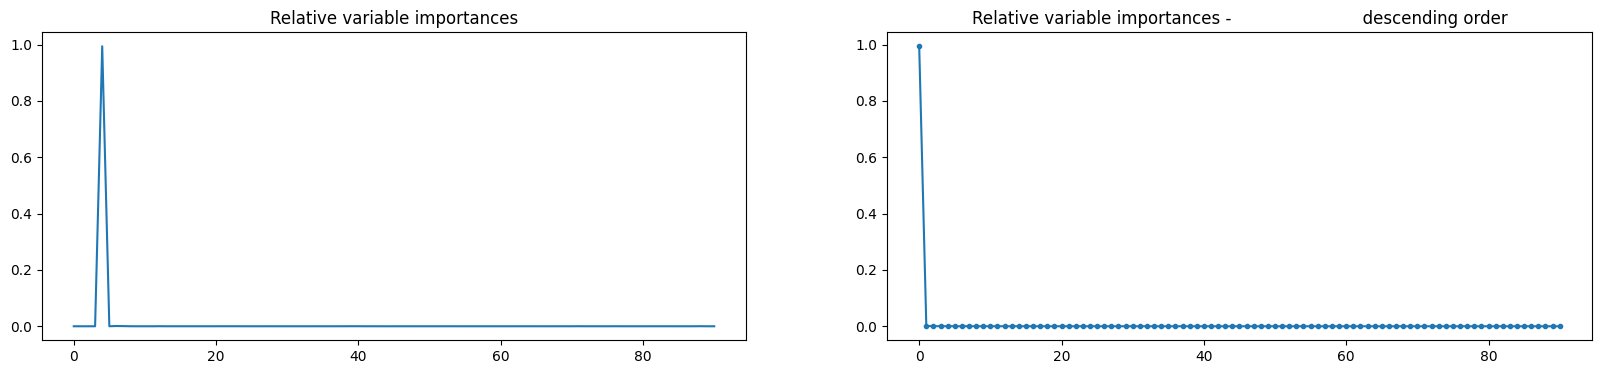

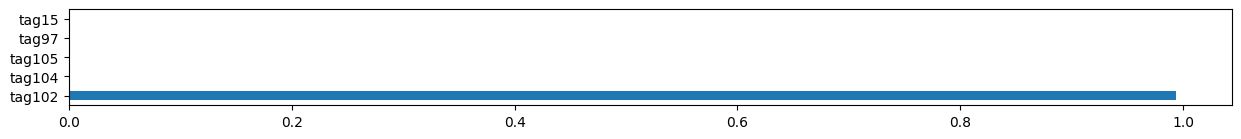

In [15]:
models[3].plot_importances(n=5)

The result above indicates that `RandomForest` was efficient in selecting only one variable of interest, out of the more than 100 variables available in the $X$ dataset.

For a fairer comparison of the models' performances themselves, excluding their ability to select variables, it is useful to recalculate the comparative table using only the variable identified by the `RandomForest` as the $X$ dataset.

CPU times: total: 6.62 s
Wall time: 6.58 s


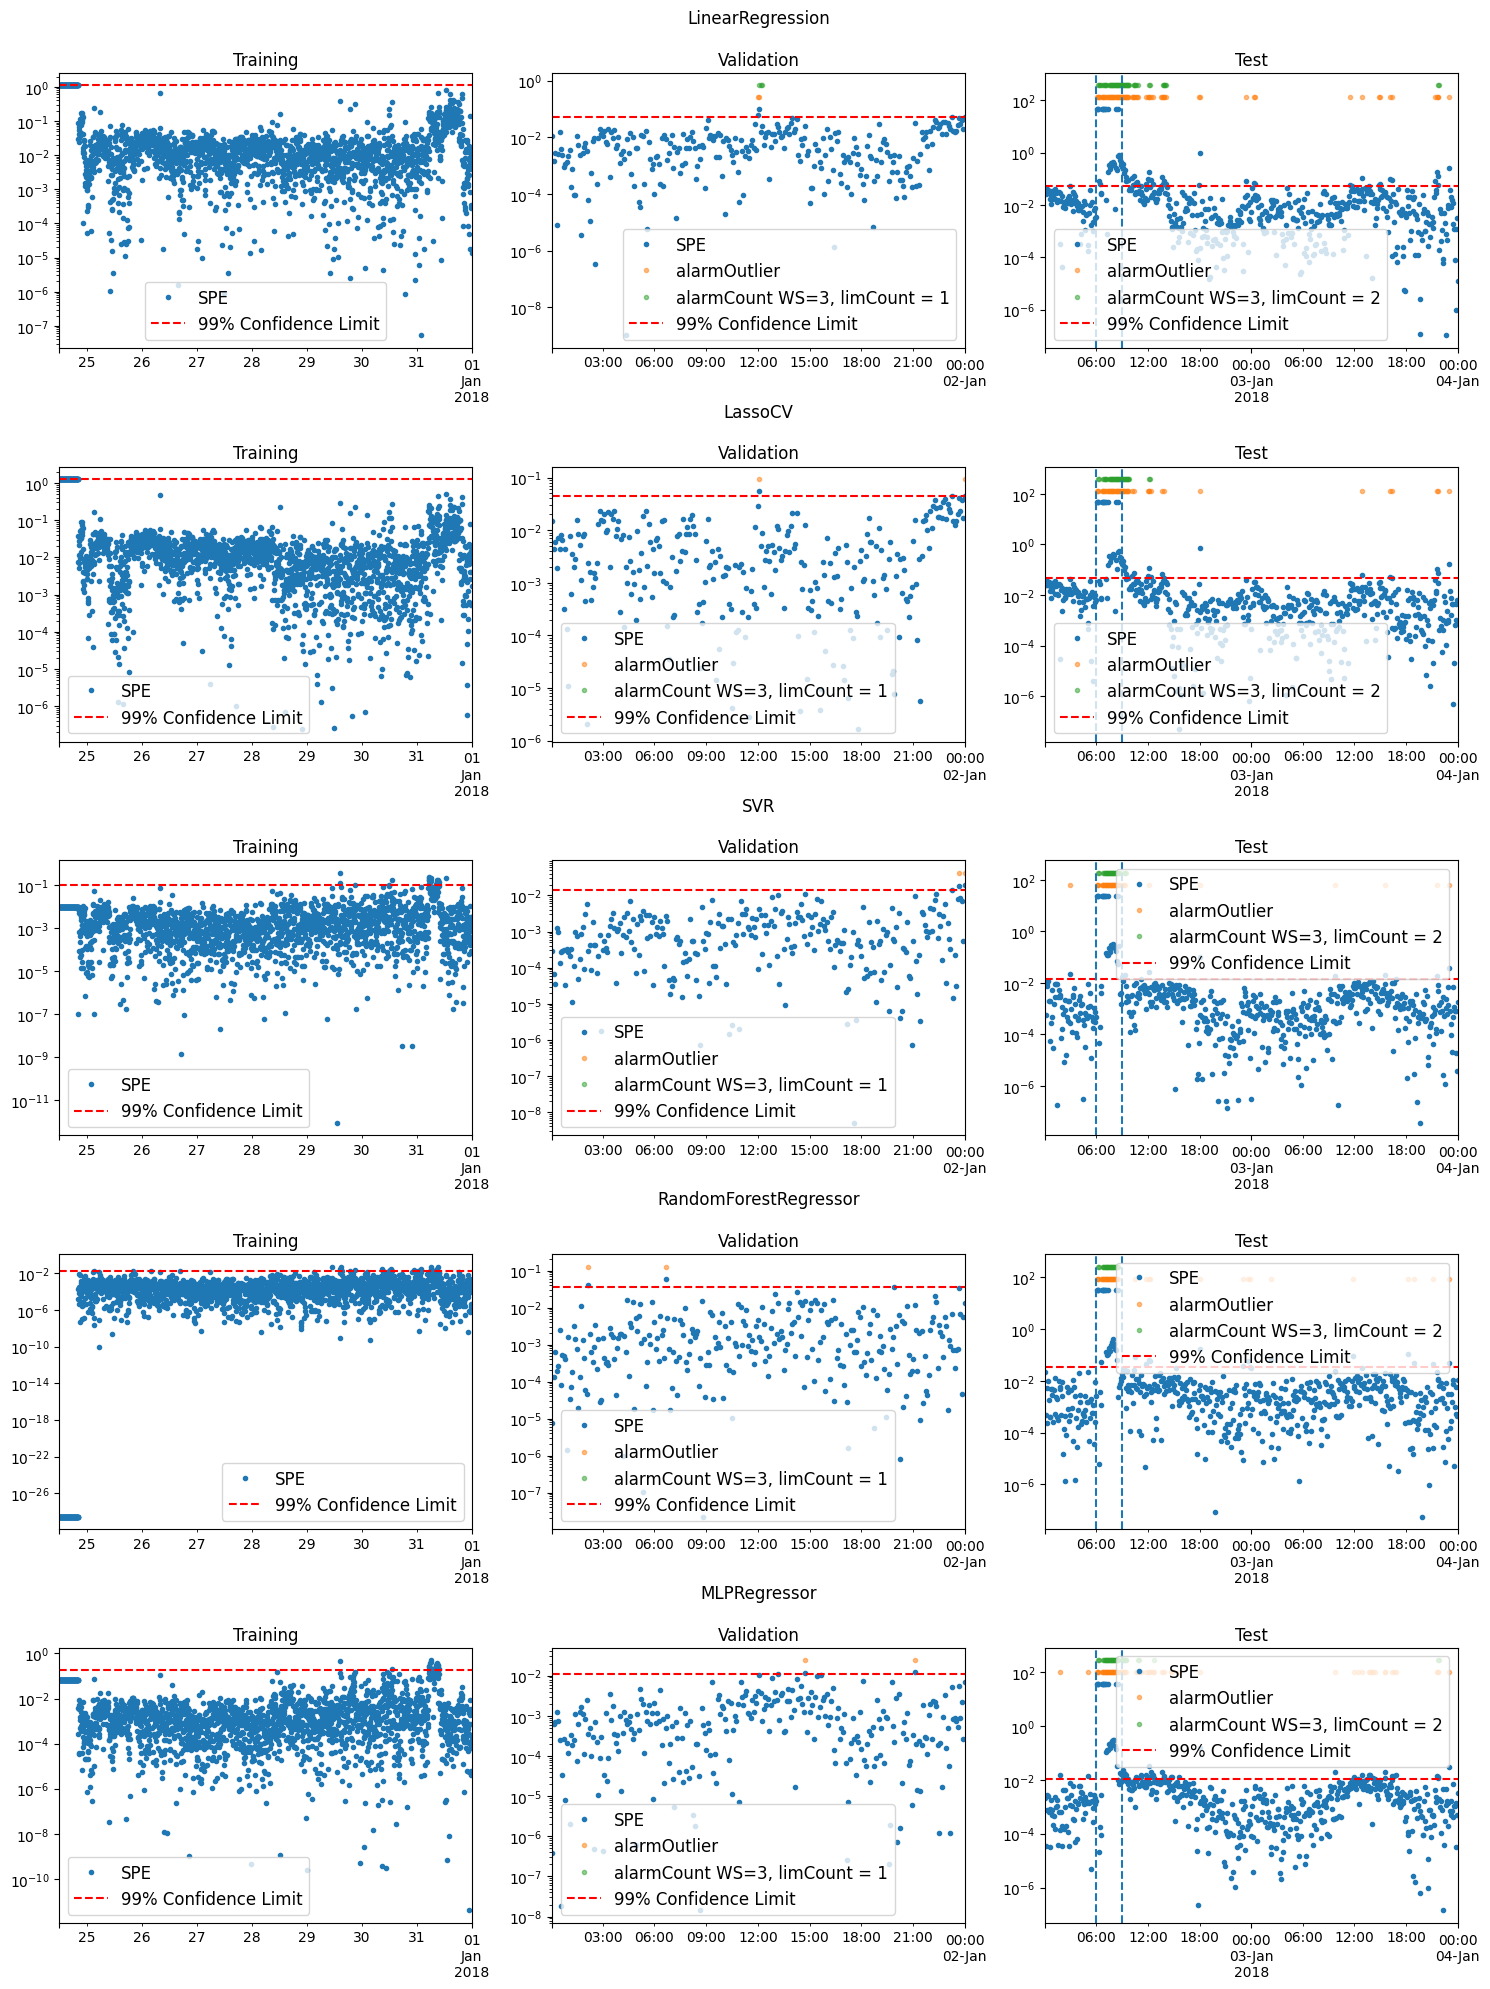

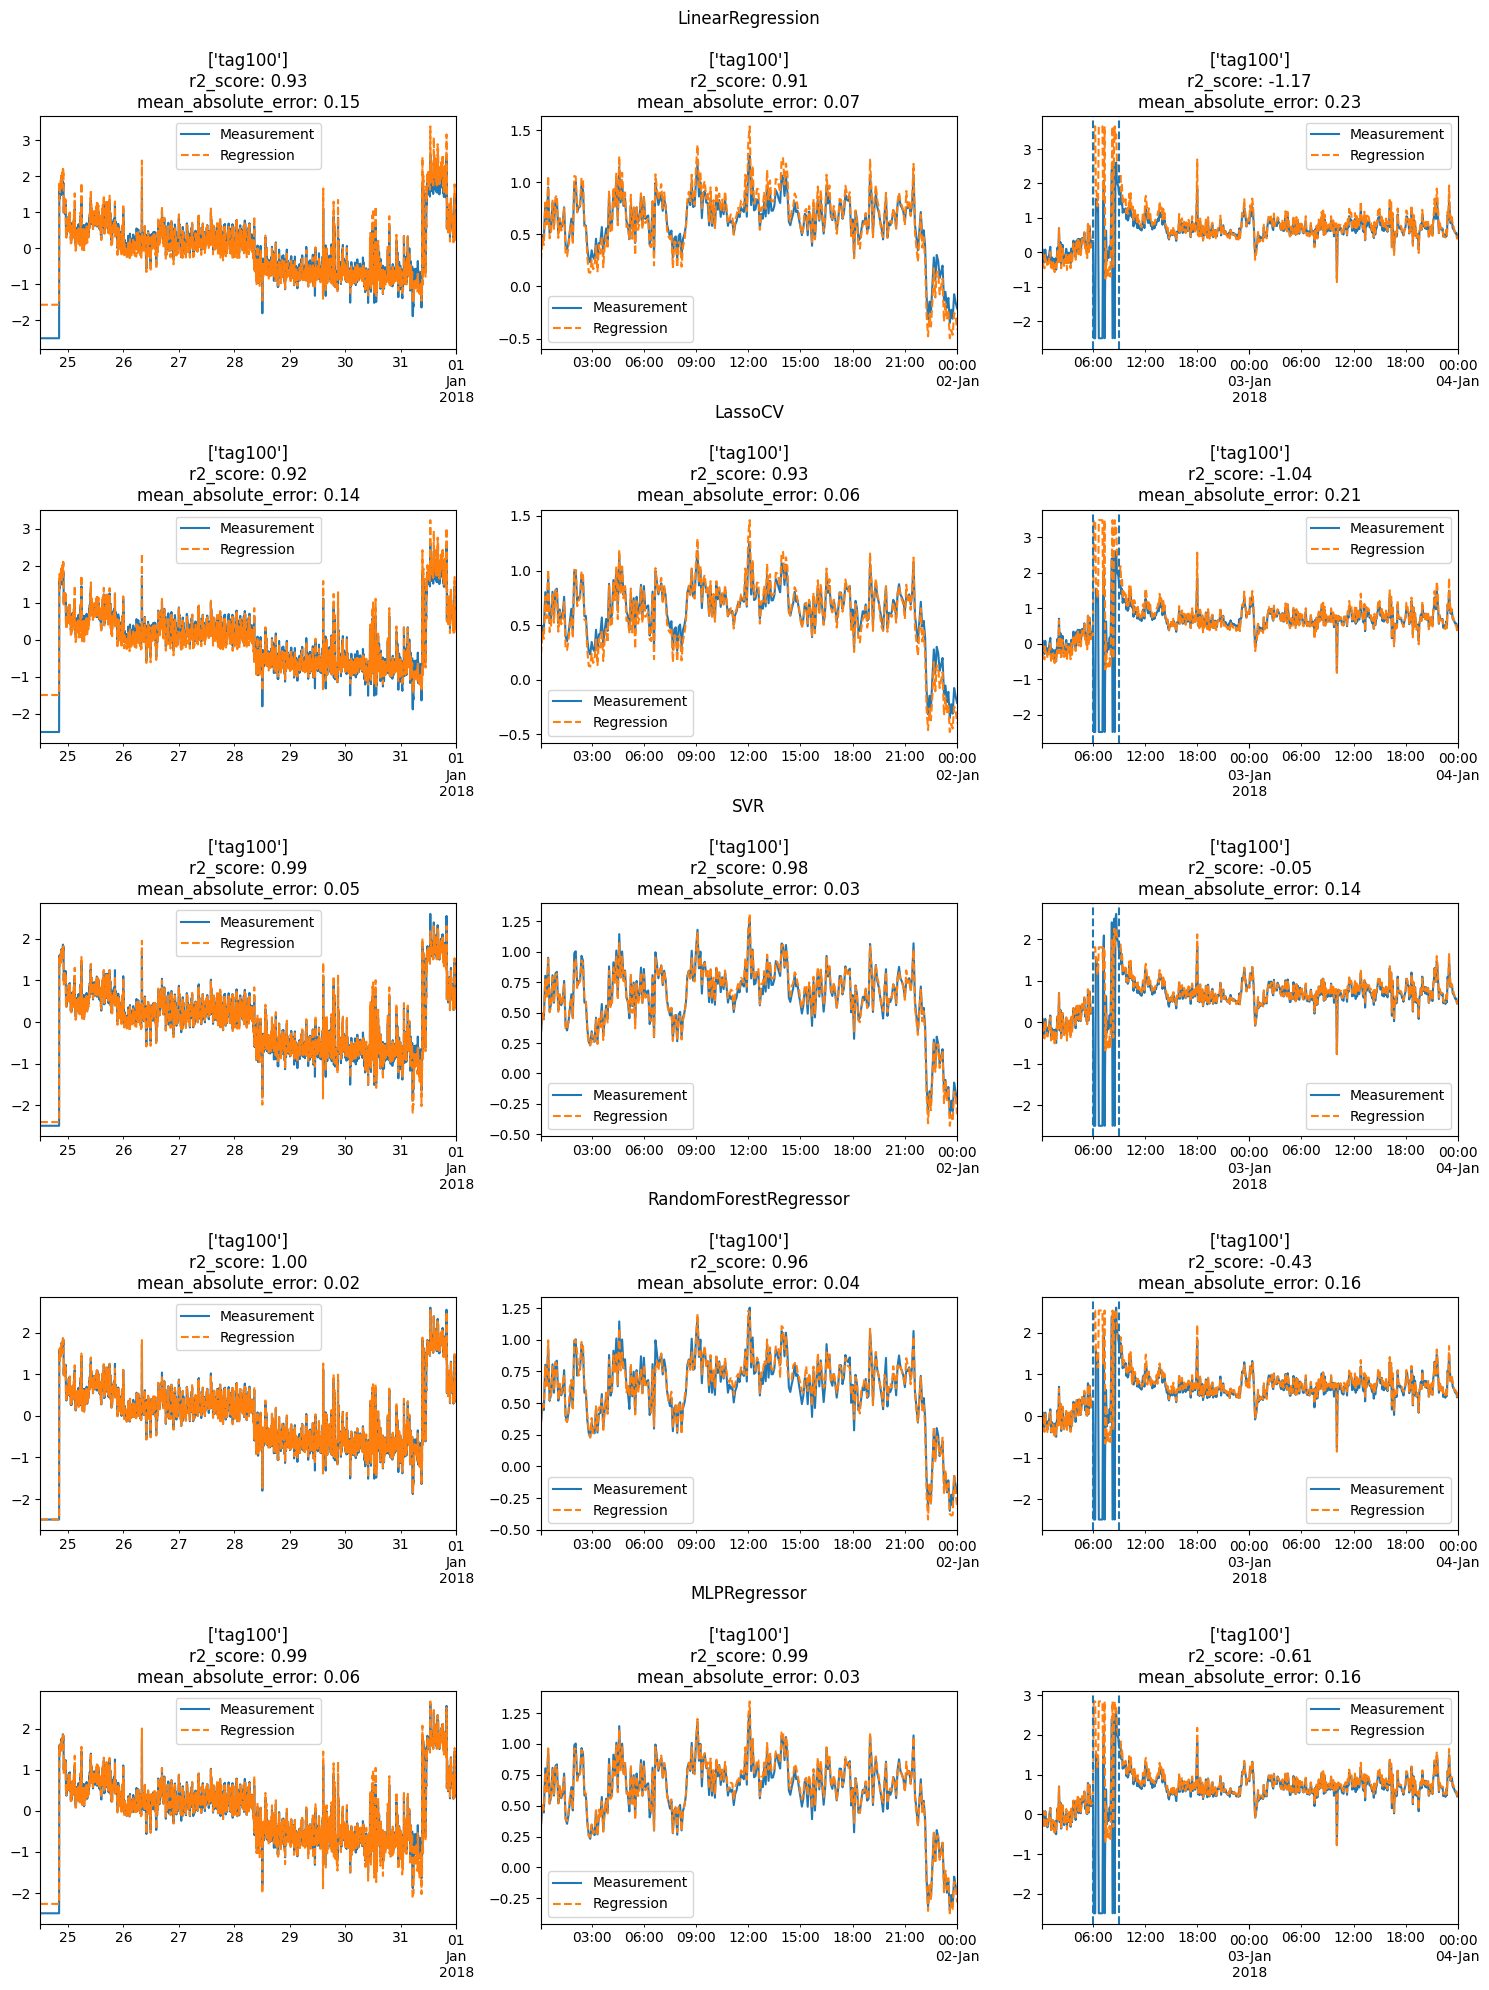

In [16]:
%%time

tab_pred, tab_detec, tab_times = bibmon.comparative_table(models, X_train['tag102'], 
                                                          X_validation['tag102'], X_test['tag102'], 
                                                          Y_train, Y_validation, Y_test,                      
                                                          metrics = mtr, count_window_size = 3, 
                                                          count_limit = 2,
                                                          fault_start = '2018-01-02 06:00:00',
                                                          fault_end = '2018-01-02 09:00:00')      

In [17]:
display(tab_pred.round(3))
display(tab_detec.round(3))
display(tab_times.round(2))

Train  Validation   Test
Metrics             Models                                         
mean_absolute_error LassoCV                0.139       0.057  0.207
                    LinearRegression       0.147       0.066  0.234
                    MLPRegressor           0.056       0.026  0.162
                    RandomForestRegressor  0.018       0.039  0.164
                    SVR                    0.047       0.028  0.135
r2_score            LassoCV                0.924       0.931 -1.035
                    LinearRegression       0.926       0.910 -1.175
                    MLPRegressor           0.988       0.986 -0.606
                    RandomForestRegressor  0.999       0.964 -0.435
                    SVR                    0.994       0.983 -0.048

FDR    FAR
Alarms                        Models                             
alarmCount WS=3, limCount = 2 LassoCV                0.694  0.024
                              LinearRegression       0.750  0.046
                              MLPRegressor           0.667  0.022
                              RandomForestRegressor  0.694  0.000
                              SVR                    0.722  0.006
alarmOutlier                  LassoCV                0.778  0.044
                              LinearRegression       0.833  0.083
                              MLPRegressor           0.778  0.080
                              RandomForestRegressor  0.750  0.026
                              SVR                    0.778  0.020

,Train,Test
LinearRegression,0.54,0.00
LassoCV,20.79,0.00
SVR,23.71,10.41
RandomForestRegressor,103.46,81.46
MLPRegressor,377.22,0.00


It can be concluded that by using only the relevant variable, the other models achieve comparable performances to the `RandomForest` model.

## Final considerations

In this notebook, an example of offline monitoring study was presented using the `complete_analysis` and `comparative_table` functions.

For a more flexible example of using `BibMon` functionalities, please refer to the [tutorial_tep.ipynb](https://bibmon.readthedocs.io/en/latest/tutorial_tep.html) notebook, where lower-level functions are used to perform the analyses.